SECTION 0): Initial upfront stuff

In [32]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter


#from sklearn.neighbors import NearestNeighbors


In [12]:
#Importing data
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [13]:
#Figuring out dimensions
print(len(df.index))
for column in df[:]:
    print(column, df[column].dtype)

41188
age int64
job object
marital object
education object
default object
housing object
loan object
contact object
month object
day_of_week object
duration int64
campaign int64
pdays int64
previous int64
poutcome object
emp.var.rate float64
cons.price.idx float64
cons.conf.idx float64
euribor3m float64
nr.employed float64
y object


In [14]:
#Any missing values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [15]:
#Quick descriptives on continuous variables
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


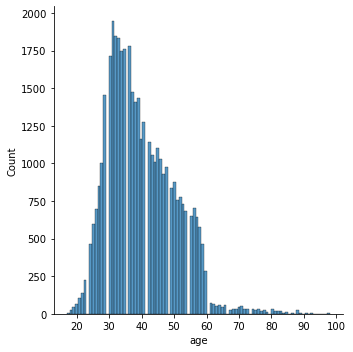

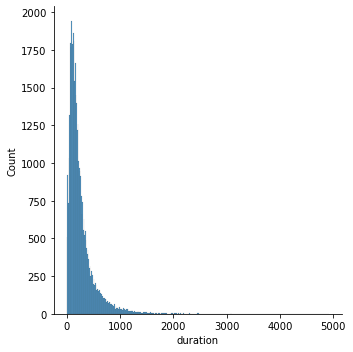

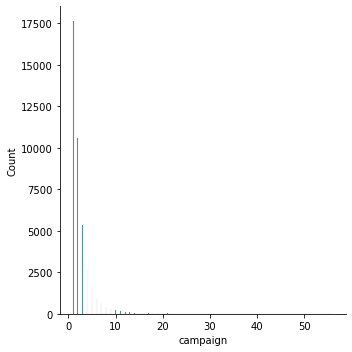

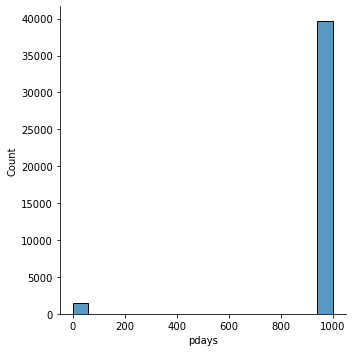

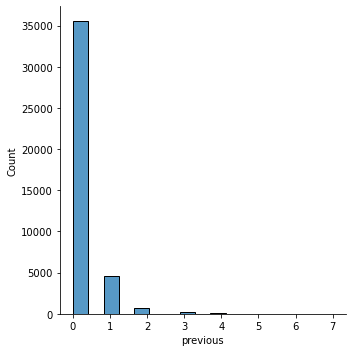

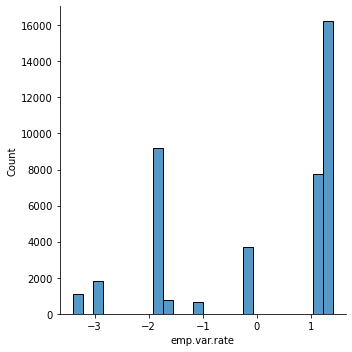

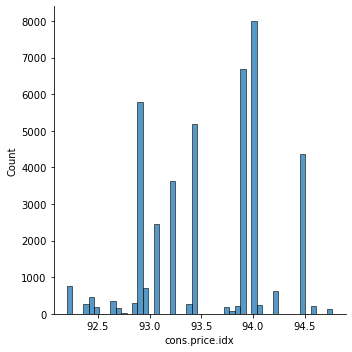

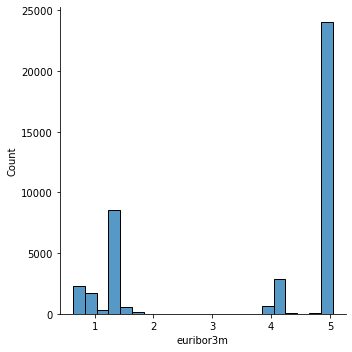

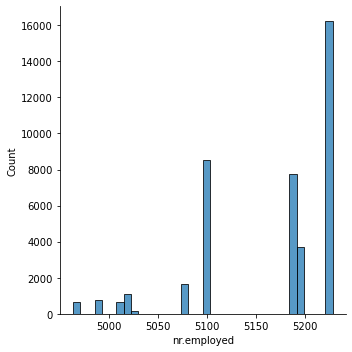

In [16]:
#Plotting continuous data
for column in df[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                    'euribor3m', 'nr.employed']]:
    sns.displot(df[column], x=df[column])

In [17]:
#Examining categorical data
for column in df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']]:
    CT = pd.crosstab(index=df[column], columns='count')
    print(column, CT.sort_values('count', ascending=False))

job col_0          count
job                 
admin.         10422
blue-collar     9254
technician      6743
services        3969
management      2924
retired         1720
entrepreneur    1456
self-employed   1421
housemaid       1060
unemployed      1014
student          875
unknown          330
marital col_0     count
marital        
married   24928
single    11568
divorced   4612
unknown      80
education col_0                count
education                 
university.degree    12168
high.school           9515
basic.9y              6045
professional.course   5243
basic.4y              4176
basic.6y              2292
unknown               1731
illiterate              18
default col_0    count
default       
no       32588
unknown   8597
yes          3
housing col_0    count
housing       
yes      21576
no       18622
unknown    990
loan col_0    count
loan          
no       33950
yes       6248
unknown    990
contact col_0      count
contact         
cellular   26144
telephone  15

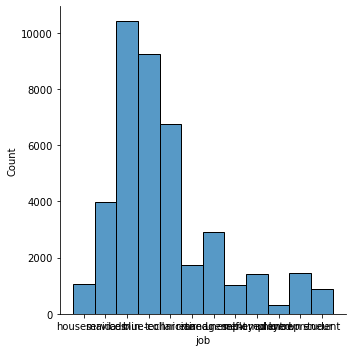

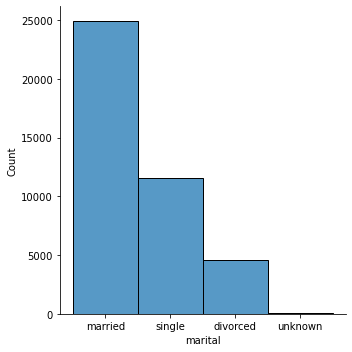

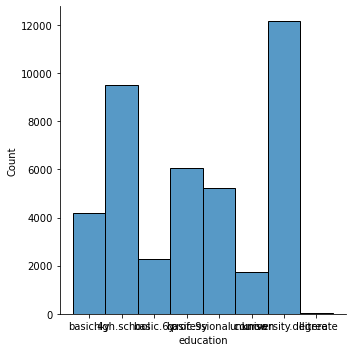

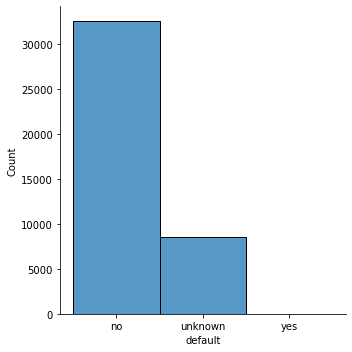

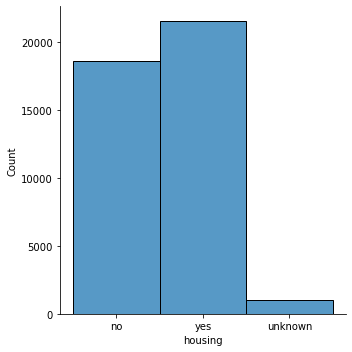

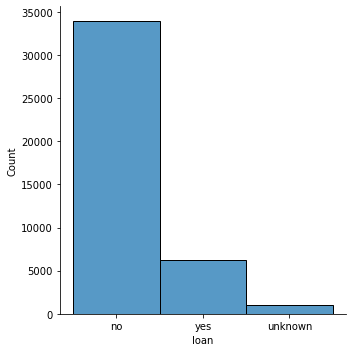

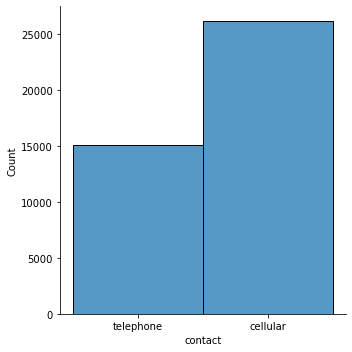

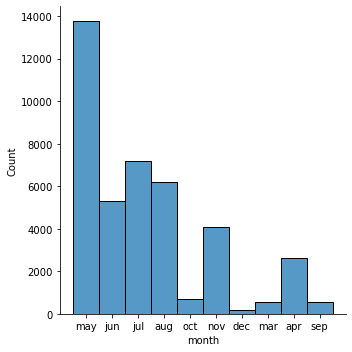

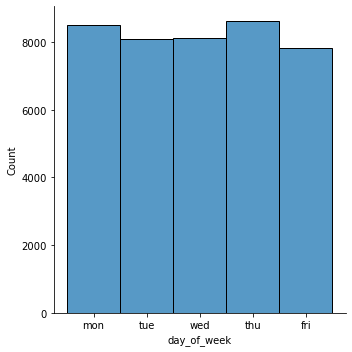

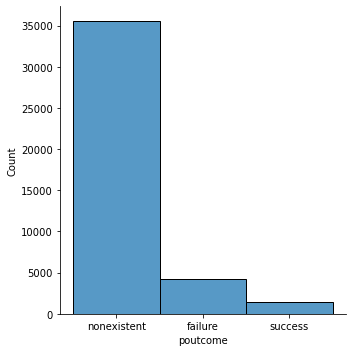

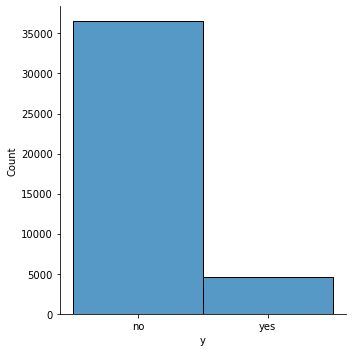

In [18]:
#Plotting categorical
for column in df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']]:
    sns.displot(df[column], x=df[column])

Initial thoughts:
- No missing values -- great
- The only continuous variable that really looks like it's got some wild outliers is the 'duration', so may want to winsorize
- The y variable, which we're trying to predict, is pretty imbalanced, so I'm gonna run one model with all obs and another with matched samples

SECTION 1): Data cleaning

In [19]:
#Winsorizing the duration variable
df['duration'].describe()

df['duration_new'] = np.where(df['duration'] > ((3*df['duration'].std()) + df['duration'].mean()), 
    ((3*df['duration'].std()) + df['duration'].mean()), 
    df['duration'])

print(df['duration'].describe(), df['duration_new'].describe())

count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64 count    41188.000000
mean       250.874106
std        221.728117
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       1036.122757
Name: duration_new, dtype: float64


SECTION 2) Predicting y using full sample

In [20]:
#Splitting out IVs and DVs
y = np.array(df.iloc[:, -2])
x = df.iloc[:, :-2]

for column in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']:
    x[column] = x[column].astype('category')

x.info()
print(y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   default         41188 non-null  category
 5   housing         41188 non-null  category
 6   loan            41188 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  int64   
 11  campaign        41188 non-null  int64   
 12  pdays           41188 non-null  int64   
 13  previous        41188 non-null  int64   
 14  poutcome        41188 non-null  category
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

In [21]:
#Encoding categoricals
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), 
    ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'])],
    remainder='passthrough')
x = np.array(ct.fit_transform(x))

In [22]:
#Encoding the DV
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[0 0 0 ... 0 1 0]


SECTION 2a): Model with straightforward training/testing sets

In [23]:
#Splitting training from test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [24]:
#Feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [25]:
#Building random forest classifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [26]:
#Predicting results
y_pred = classifier.predict(x_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [27]:
cm = confusion_matrix(y_test, y_pred)
print(cm, accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred))

[[8913  226]
 [ 729  429]] 0.9072545401573274 0.6728685693098019


Got good accuracy with the full sample -- 91% -- but ROC-AUC score is only .688

SECTION 2b): Model with k-fold cross validation (for fun)

In [28]:
#Feature scaling whole sample -- CAUTION: don't re-use this 'x' matrix when splitting into train/test later (re-make x)
sc = StandardScaler()
x = sc.fit_transform(x)

In [29]:
#Building random forest classifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(classifier, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % scores.mean()) #Much better ROC-AUC score here!

Mean ROC AUC: 0.914


SECTION 3): Creating matched samples dataframe and re-running random forest
(Side note: I had trouble finding an easy matched-samples approach in Python -- R has a great package to accomplish this, match.it -- so I did some investigating, and it appears that the SMOTE technique is a suitable way to handle imbalanced data, so I will explore that here. Credit to Jason Brownlee and this article for illuminating me: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [30]:
#Feature scaling full sample
sc = StandardScaler()
x = sc.fit_transform(x)

In [33]:
#Pre-SMOTE distribution of y values
print(Counter(y))

Counter({0: 36548, 1: 4640})


In [34]:
#Creating and implementing SMOTE object
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [35]:
#Post-SMOTE distribution of y values
print(Counter(y))

Counter({0: 36548, 1: 36548})


In [36]:
#Running a new Random Forest model
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(classifier, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % scores.mean()) #Up to .991 -- actually shockingly good

Mean ROC AUC: 0.991


So the near perfect AUC score using the k-folds cross validation really demonstrates just how effective this SMOTE method is. However, I want to just run it using split training/testing data to see how the accuracy scores differ

In [40]:
#Have to remake the variables prior to split since already feature scaled x previously
y = np.array(df.iloc[:, -2])
x = df.iloc[:, :-2]

for column in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']:
    x[column] = x[column].astype('category')

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), 
    ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'])],
    remainder='passthrough')
x = np.array(ct.fit_transform(x))

le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[0 0 0 ... 0 1 0]


In [41]:
#Creating and implementing SMOTE object
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [42]:
#Splitting into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [43]:
#Feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [44]:
#Building random forest classifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [45]:
#Creating predicted values
y_pred = classifier.predict(x_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [1 1]
 [1 1]
 ...
 [1 1]
 [0 0]
 [0 0]]


In [46]:
#Viewing how it performed
cm = confusion_matrix(y_test, y_pred)
print(cm, accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)) #Again, significantly significantly better performance here with SMOTE

[[8710  307]
 [ 639 8618]] 0.9482324614205976 0.9484621782371658
